## 도로 위험 등급별 온도 통계 분석 및 시각화

위험 등급별 온도 통계:
  RSK_ELMN_GRD  min_temp  max_temp  mean_temp  median_temp
0            E         0         6   2.716981          3.0
1            F         0         6   1.592375          1.0
2            G         0         4   0.905660          0.0
3            J        -6        -1  -1.314103         -1.0
4            L        -4        -1  -1.135900         -1.0

중앙값을 기준으로 한 온도 경계:
E-F: 2.00°C
F-G: 0.50°C
G-J: -0.50°C
J-L: -1.00°C


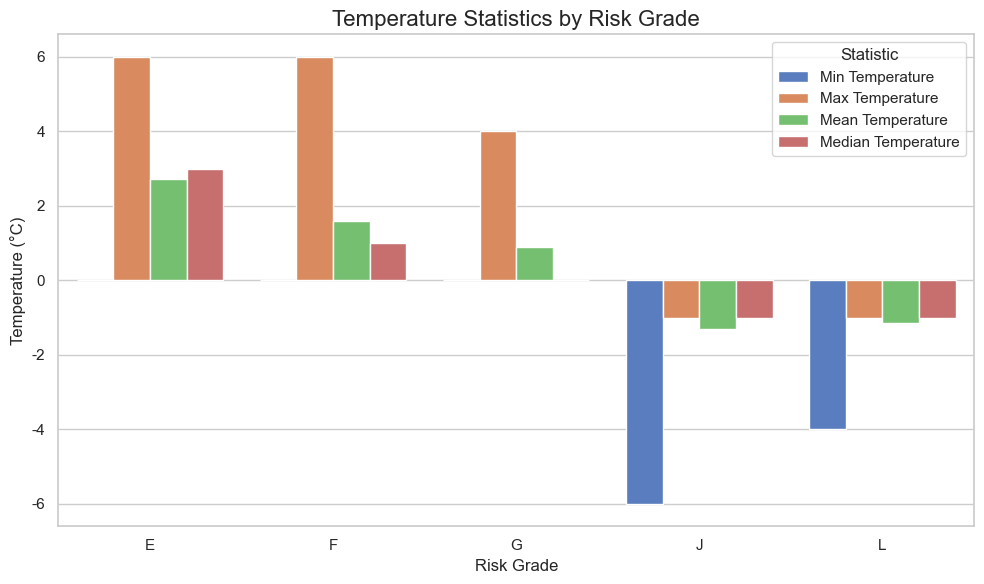

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pickle  # 데이터를 저장하기 위해 사용

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows에서의 올바른 폰트 경로 사용
font_prop = fm.FontProperties(fname=font_path)

# matplotlib에 폰트 적용
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 올바르게 표시되도록 설정

# 데이터셋 로드
df = pd.read_csv("도로위험상황예보.csv")

# 분석에 필요한 컬럼 선택
columns_of_interest = ["RSK_ELMN_GRD", "RN_1HR", "AIRTP", "LAT", "LOT"]
df = df[columns_of_interest]

# 위험 등급을 숫자 값으로 매핑
grade_mapping = {"E": 1, "F": 2, "G": 3, "J": 4, "L": 5}
inverse_mapping = {1: "E", 2: "F", 3: "G", 4: "J", 5: "L"}
df["RSK_ELMN_GRD"] = df["RSK_ELMN_GRD"].map(grade_mapping)

# AIRTP를 숫자로 변환, 숫자가 아닌 값은 NaN으로 설정
df["AIRTP"] = pd.to_numeric(df["AIRTP"], errors="coerce")

# 'AIRTP' 또는 'RSK_ELMN_GRD'에 결측치가 있는 행 삭제
df = df.dropna(subset=["AIRTP", "RSK_ELMN_GRD"])

# 위험 등급별 온도 통계 계산
grade_stats = df.groupby("RSK_ELMN_GRD")["AIRTP"].agg(
    min_temp="min",
    max_temp="max",
    mean_temp="mean",
    median_temp="median"
).reset_index()

# 위험 등급을 다시 문자 값으로 매핑
grade_stats["RSK_ELMN_GRD"] = grade_stats["RSK_ELMN_GRD"].map(inverse_mapping)

# 중앙값을 기준으로 한 온도 경계 계산
boundaries = {}
for i in range(len(grade_stats) - 1):
    grade1, grade2 = grade_stats.iloc[i], grade_stats.iloc[i + 1]
    boundaries[f"{grade1['RSK_ELMN_GRD']}-{grade2['RSK_ELMN_GRD']}"] = (
        grade1["median_temp"] + grade2["median_temp"]
    ) / 2

# F, G, L의 median_temp 값을 모듈 변수로 저장
try:
    temp_00 = grade_stats.loc[grade_stats["RSK_ELMN_GRD"] == "F", "median_temp"].values[0]
    temp_01 = grade_stats.loc[grade_stats["RSK_ELMN_GRD"] == "J", "median_temp"].values[0]   
except IndexError:
    temp_00, temp_01 = None, None

# 데이터를 pickle 파일로 저장
with open("temperature_data.pkl", "wb") as f:
    pickle.dump({"temp_00": temp_00, "temp_01": temp_01}, f)

# 온도 통계 출력
print("위험 등급별 온도 통계:")
print(grade_stats)
print("\n중앙값을 기준으로 한 온도 경계:")
for boundary, temp in boundaries.items():
    print(f"{boundary}: {temp:.2f}°C")

# 위험 등급별 온도 통계 시각화
sns.set(style="whitegrid")

# 각 위험 등급에 대한 온도 통계 플롯
fig, ax = plt.subplots(figsize=(10, 6))

# 플롯에서 읽기 쉽게 컬럼 이름 변경
stat_name_mapping = {
    "min_temp": "Min Temperature",
    "max_temp": "Max Temperature",
    "mean_temp": "Mean Temperature",
    "median_temp": "Median Temperature"
}

grade_stats_long = grade_stats.rename(columns=stat_name_mapping).melt(
    id_vars=["RSK_ELMN_GRD"],
    value_vars=list(stat_name_mapping.values()),
    var_name="Statistic",
    value_name="Temperature"
)

sns.barplot(
    data=grade_stats_long,
    x="RSK_ELMN_GRD",
    y="Temperature",
    hue="Statistic",
    palette="muted",
    ax=ax
)

# 제목과 라벨 추가
ax.set_title("Temperature Statistics by Risk Grade", fontsize=16)
ax.set_xlabel("Risk Grade", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.legend(title="Statistic")

plt.tight_layout()
plt.show()
